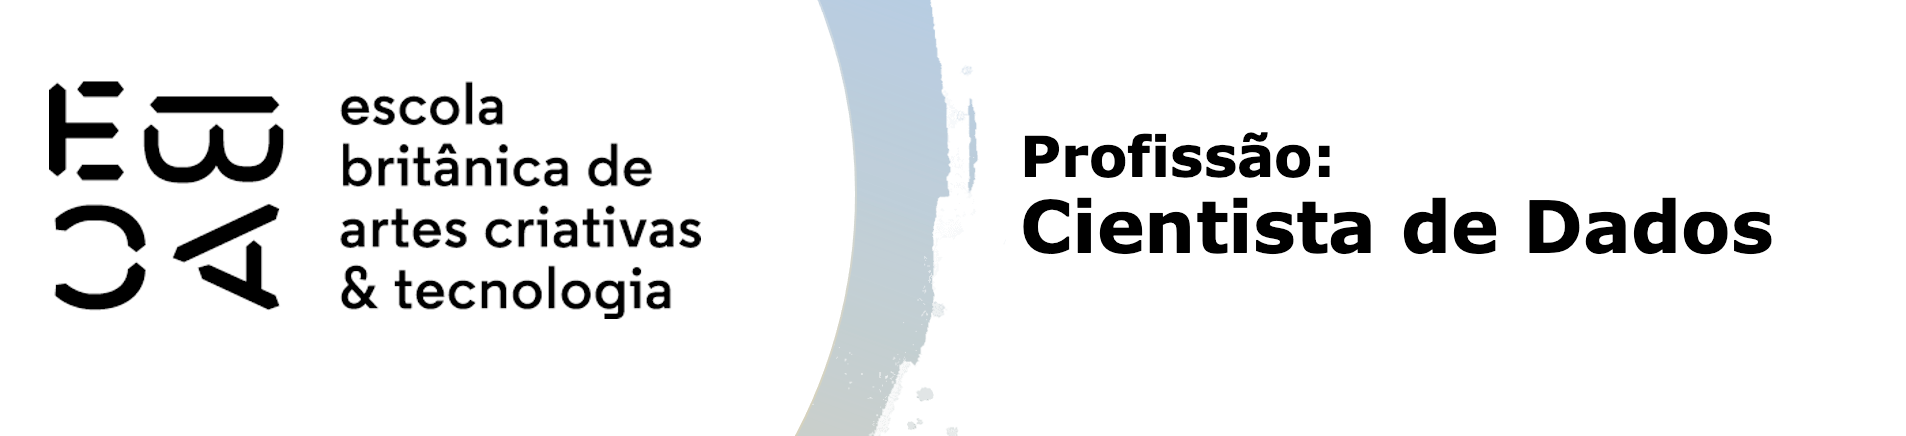

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [27]:
pip install --upgrade --force-reinstall matplotlib seaborn



  Using cached matplotlib-3.9.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.53.1-cp312-cp312-win_amd64.whl.metadata (165 kB)
  Using cached kiwisolver-1.4.5-cp312-cp312-win_amd64.whl.metadata (6.5 kB)
     ---------------------------------------- 0.0/59.7 kB ? eta -:--:--
     ------ --------------------------------- 10.2/59.7 kB ? eta -:--:--
     ------ --------------------------------- 10.2/59.7 kB ? eta -:--:--
     -------------------------- ----------- 41.0/59.7 kB 281.8 kB/s eta 0:00:01
     -------------------------------------- 59.7/59.7 kB 353.6 kB/s eta 0:00:00
  Using cached packaging-24.1-py3-none-any.whl.metadata (3.2 kB)
  Using cached pillow-10.4.0-cp312-cp312-win_amd64.whl.metadata (9.3 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pandas-2.2.2-cp312-cp312-win_a

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: Cannot uninstall matplotlib 3.9.2, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps matplotlib==3.9.2'.


In [28]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import numpy as np

df = pd.read_feather('credit_scoring.ftr')
df.shape
df


ImportError: cannot import name 'Axes' from 'matplotlib.axes' (unknown location)

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [ ]:
df = df.drop('index', axis=1)
df.tail()

In [ ]:
# Converter 'data_ref' para datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Separar os três últimos meses para validação *out of time*
last_three_months = df['data_ref'].max() - pd.DateOffset(months=3)
oot_df = df[df['data_ref'] > last_three_months]
train_df = df[df['data_ref'] < last_three_months]

In [6]:
df = oot_df
df

NameError: name 'oot_df' is not defined

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [11]:
# Número total de linhas
total_rows = len(oot_df)

# Número de linhas para cada mês
monthly_counts = oot_df['data_ref'].value_counts().sort_index()

total_rows, monthly_counts

(150000,
 data_ref
 2016-01-01    50000
 2016-02-01    50000
 2016-03-01    50000
 Name: count, dtype: int64)

In [13]:
# Descrição básica das variáveis quantitativas
quantitative_vars = oot_df.select_dtypes(include=['float64', 'int64'])
quantitative_description = quantitative_vars.describe()

# Descrição básica das variáveis qualitativas
qualitative_vars = oot_df.select_dtypes(include=['object'])
qualitative_description = {col: oot_df[col].value_counts() for col in qualitative_vars.columns}

quantitative_description, qualitative_description


(          qtd_filhos          idade  tempo_emprego  qt_pessoas_residencia  \
 count  150000.000000  150000.000000  124918.000000          150000.000000   
 mean        0.433413      43.829547       7.750898               2.212720   
 std         0.737417      11.226707       6.682998               0.902114   
 min         0.000000      22.000000       0.117808               1.000000   
 25%         0.000000      34.000000       3.071233               2.000000   
 50%         0.000000      43.000000       6.038356               2.000000   
 75%         1.000000      53.000000      10.183562               3.000000   
 max        14.000000      68.000000      42.906849              15.000000   
 
                renda  
 count  150000.000000  
 mean     7301.344809  
 std     20778.675831  
 min       107.670000  
 25%      1598.627500  
 50%      2952.380000  
 75%      5858.200000  
 max    732561.260000  ,
 {'sexo': sexo
  F    100775
  M     49225
  Name: count, dtype: int64,
  'poss

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

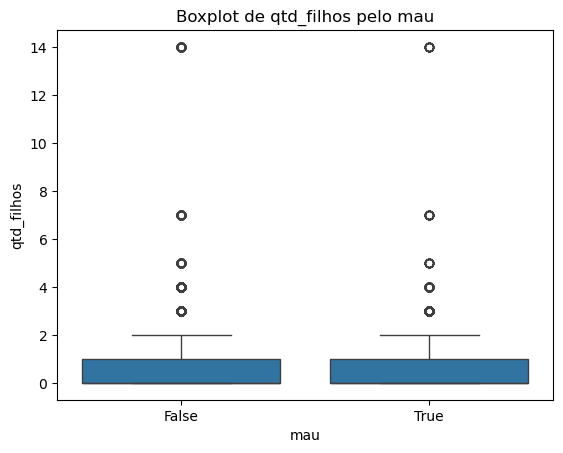

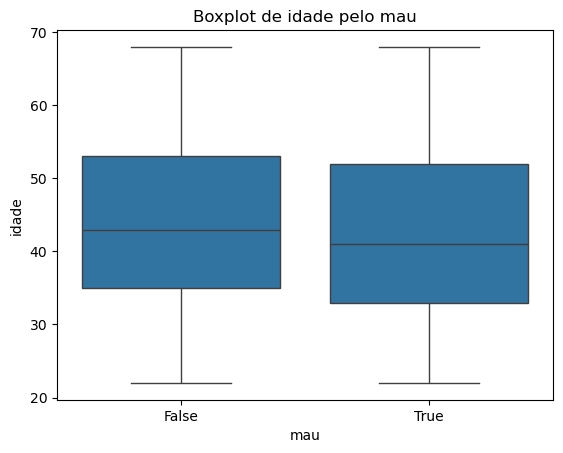

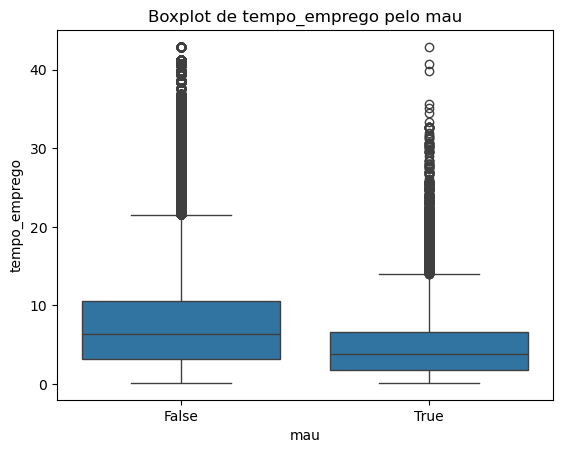

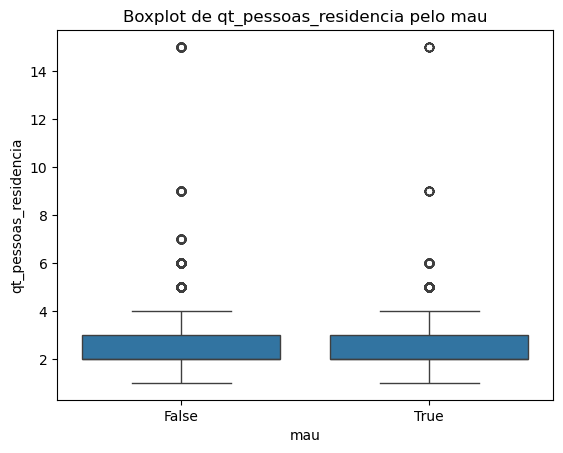

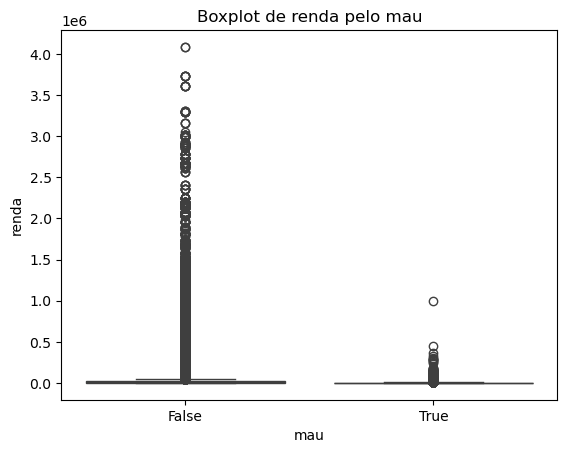

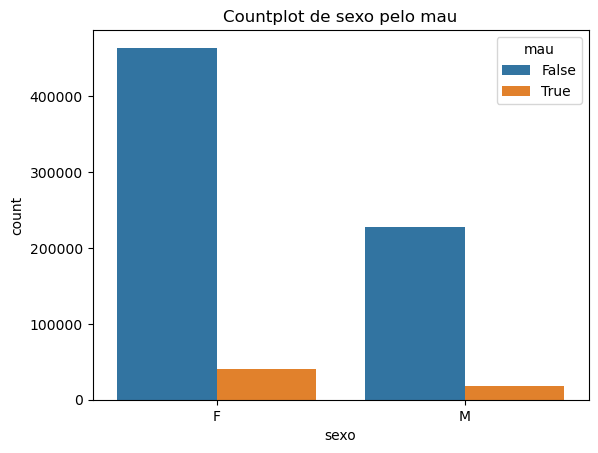

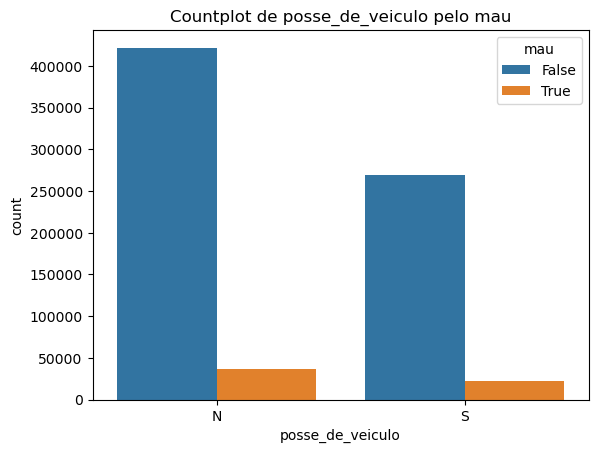

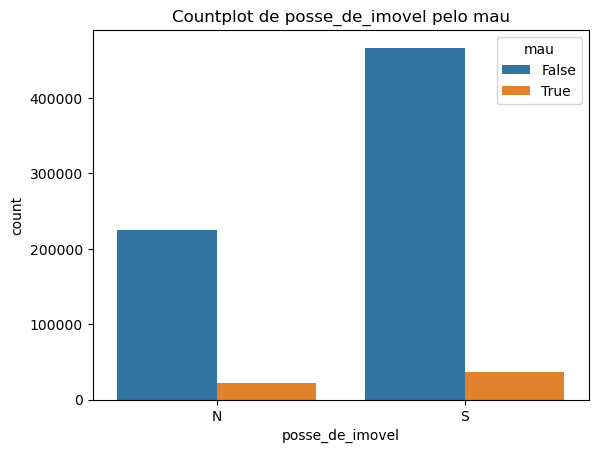

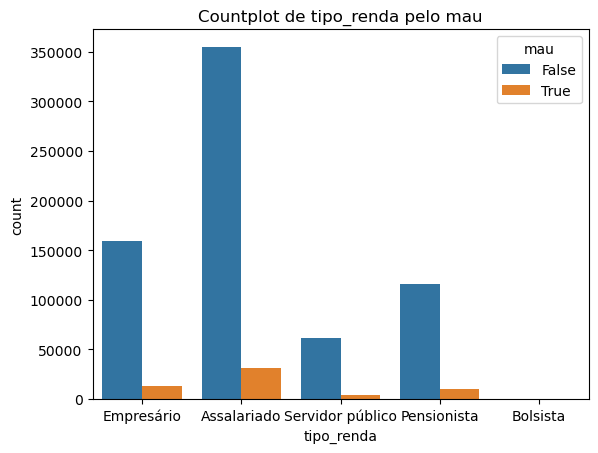

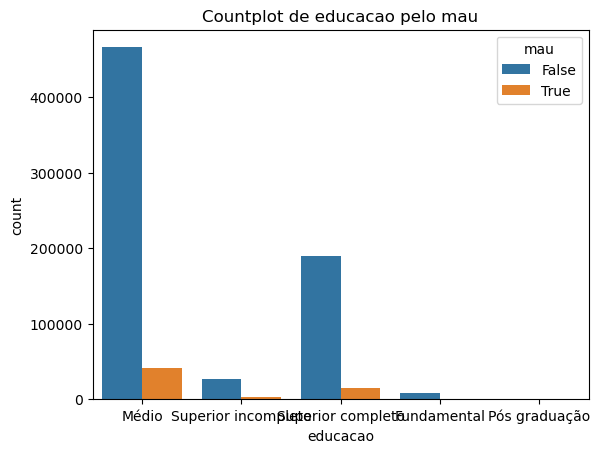

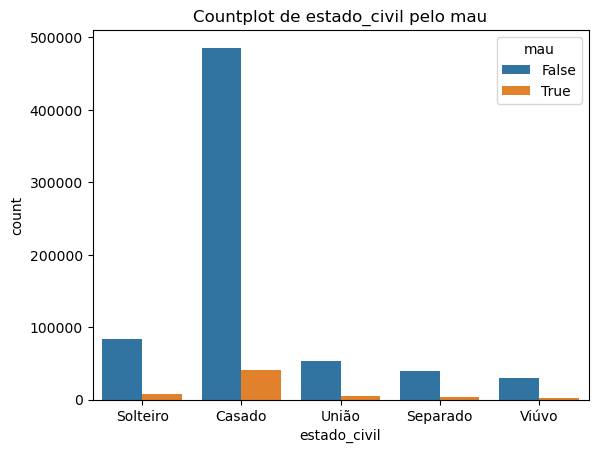

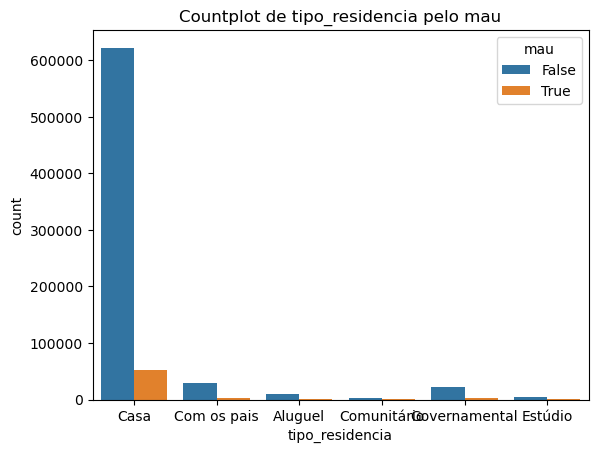

In [15]:
# Visualizações bivariadas
for col in quantitative_vars.columns:
    sns.boxplot(data=df, x='mau', y=col)
    plt.title(f'Boxplot de {col} pelo mau')
    plt.show()

# Para variáveis qualitativas vs. 'mau'
for col in qualitative_vars.columns:
    if col != 'data_ref' and col != 'index':
        sns.countplot(data=df, x=col, hue='mau')
        plt.title(f'Countplot de {col} pelo mau')
        plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 600000 to 749999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               150000 non-null  datetime64[ns]
 1   sexo                   150000 non-null  object        
 2   posse_de_veiculo       150000 non-null  object        
 3   posse_de_imovel        150000 non-null  object        
 4   qtd_filhos             150000 non-null  int64         
 5   tipo_renda             150000 non-null  object        
 6   educacao               150000 non-null  object        
 7   estado_civil           150000 non-null  object        
 8   tipo_residencia        150000 non-null  object        
 9   idade                  150000 non-null  int64         
 10  tempo_emprego          124918 non-null  float64       
 11  qt_pessoas_residencia  150000 non-null  float64       
 12  renda                  150000 non-null  floa

In [16]:
# Tratamento de valores missing
df = df.fillna({
    'tempo_emprego': df['tempo_emprego'].median()
})

# Exemplo de tratamento de outliers para uma variável quantitativa
df = df[(np.abs(stats.zscore(df['tempo_emprego'].fillna(df['tempo_emprego'].median()))) < 3)]


In [17]:
# Exemplos de tratamento de zeros estruturais
df['qtd_filhos'] = df['qtd_filhos'].replace(0, df['qtd_filhos'].mode()[0])


In [18]:
df['educacao'].value_counts()

educacao
Médio                  494049
Superior completo      200942
Superior incompleto     29107
Fundamental              8516
Pós graduação             812
Name: count, dtype: int64

In [23]:
for column in df.columns:
    print(f"{column}: {df[column].value_counts().sort_values(ascending=False)}")

data_ref: data_ref
2015-06-01    48945
2015-10-01    48939
2015-01-01    48932
2015-11-01    48932
2016-02-01    48900
2015-08-01    48891
2015-09-01    48890
2015-04-01    48886
2015-07-01    48886
2015-12-01    48885
2016-03-01    48878
2015-05-01    48872
2015-03-01    48870
2016-01-01    48870
2015-02-01    48850
Name: count, dtype: int64
sexo: sexo
F    489554
M    243872
Name: count, dtype: int64
posse_de_veiculo: posse_de_veiculo
N    444571
S    288855
Name: count, dtype: int64
posse_de_imovel: posse_de_imovel
S    492972
N    240454
Name: count, dtype: int64
qtd_filhos: qtd_filhos
0     501912
1     152291
2      69207
3       8669
4       1065
7        101
5         95
14        86
Name: count, dtype: int64
tipo_renda: tipo_renda
Assalariado         374216
Empresário          170692
Pensionista         126265
Servidor público     61892
Bolsista               361
Name: count, dtype: int64
educacao: educacao
Médio                  494049
Superior completo      200942
Superior i

In [25]:
# Agrupamento de categorias menos frequentes
df['educacao'] = df['educacao'].replace({
    'Superior incompleto': 'Superior',
    
})


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [27]:
# Preparação dos dados
features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda', 
             'educacao', 'estado_civil', 'tipo_residencia', 'idade', 'tempo_emprego', 
             'qt_pessoas_residencia', 'renda']
X = pd.get_dummies(df[features], drop_first=True)
y = df['mau']

# Dividir dados para treinamento e validação
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

# Modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

# Métricas
accuracy = accuracy_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
conf_matrix = confusion_matrix(y_valid, y_pred)

# Cálculo de KS e Gini
fpr, tpr, _ = roc_curve(y_valid, model.predict_proba(X_valid)[:, 1])
ks = max(tpr - fpr)
gini = 2 * roc_auc - 1



C:\Users\jfran\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
# Exibir os resultados
print(f'Com uma acurácia de {(100*accuracy):.2f} %, o modelo está acertando a maioria das classificações, o que indica um bom desempenho geral na base de validação.')

print(f'Um AUC de {roc_auc:.4f} indica que o modelo tem uma boa capacidade de discriminação, sendo capaz de separar as classes com uma probabilidade de {(100*roc_auc):.1f}% para um classificador aleatório.')

print("\nMatriz de Confusão:")
print(conf_matrix)
print(f"\nKS: {ks:.4f}")
print(f"Gini: {gini:.4f}")

# Explicações
print("\nExplicações:")
print("Acurácia (Accuracy): Proporção de previsões corretas em relação ao total de previsões.")
print(f"   Valor: {accuracy:.4f}")

print("\nAUC-ROC (Área sob a Curva ROC): Mede a capacidade do modelo de distinguir entre as classes.")
print(f"   Valor: {roc_auc:.4f}")

print("\nMatriz de Confusão:")
print("   [TN, FP]")
print("   [FN, TP]")
print("   TN: Verdadeiros Negativos (clientes que não são inadimplentes e foram corretamente classificados).")
print("   FP: Falsos Positivos (clientes que não são inadimplentes mas foram classificados como inadimplentes).")
print("   FN: Falsos Negativos (clientes que são inadimplentes mas foram classificados como não inadimplentes).")
print("   TP: Verdadeiros Positivos (clientes que são inadimplentes e foram corretamente classificados como inadimplentes).")

print("\nKS (Kolmogorov-Smirnov): Mede a maior diferença entre as curvas de distribuição cumulativa das duas classes.")
print(f"   Valor: {ks:.4f}")

print("\nÍndice de Gini: Derivado do AUC-ROC, mede a desigualdade na distribuição das probabilidades preditivas.")
print(f"   Valor: {gini:.4f}")

Com uma acurácia de 92.07 %, o modelo está acertando a maioria das classificações, o que indica um bom desempenho geral na base de validação.
Um AUC de 0.7723 indica que o modelo tem uma boa capacidade de discriminação, sendo capaz de separar as classes com uma probabilidade de 77.2% para um classificador aleatório.

Matriz de Confusão:
[[202584      0]
 [ 17444      0]]

KS: 0.4085
Gini: 0.5447

Explicações:
Acurácia (Accuracy): Proporção de previsões corretas em relação ao total de previsões.
   Valor: 0.9207

AUC-ROC (Área sob a Curva ROC): Mede a capacidade do modelo de distinguir entre as classes.
   Valor: 0.7723

Matriz de Confusão:
   [TN, FP]
   [FN, TP]
   TN: Verdadeiros Negativos (clientes que não são inadimplentes e foram corretamente classificados).
   FP: Falsos Positivos (clientes que não são inadimplentes mas foram classificados como inadimplentes).
   FN: Falsos Negativos (clientes que são inadimplentes mas foram classificados como não inadimplentes).
   TP: Verdadeir

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [43]:
from pycaret.classification import *

ModuleNotFoundError: No module named 'pycaret'

In [15]:
dataset = df
# Verificando se existe nulos na base
dataset.isna().sum()

data_ref                 0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146648 entries, 600000 to 749999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               146648 non-null  datetime64[ns]
 1   sexo                   146648 non-null  object        
 2   posse_de_veiculo       146648 non-null  object        
 3   posse_de_imovel        146648 non-null  object        
 4   qtd_filhos             146648 non-null  int64         
 5   tipo_renda             146648 non-null  object        
 6   educacao               146648 non-null  object        
 7   estado_civil           146648 non-null  object        
 8   tipo_residencia        146648 non-null  object        
 9   idade                  146648 non-null  int64         
 10  tempo_emprego          146648 non-null  float64       
 11  qt_pessoas_residencia  146648 non-null  float64       
 12  renda                  146648 non-null  floa

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

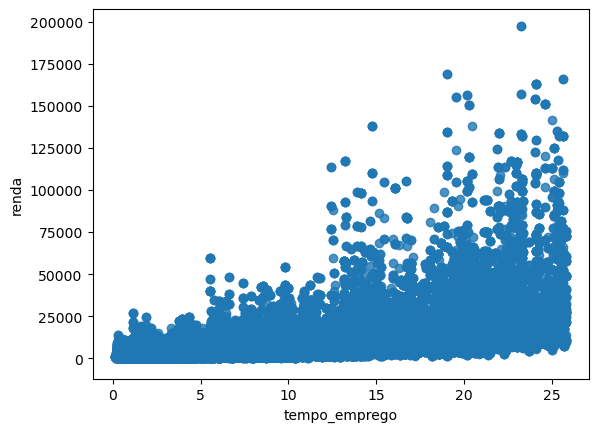

In [17]:
fig, ax = plt.subplots()

sns.regplot(x = 'tempo_emprego', y = 'renda', data=dataset, ax=ax);

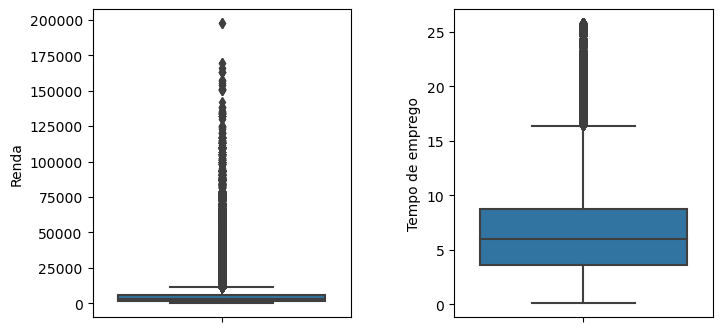

In [18]:
fix, ax = plt.subplots(1, 2, figsize=(8,4))
plt.subplots_adjust(wspace=.4, hspace=0)

sns.boxplot(y = 'renda',data=dataset, ax=ax[0])
sns.boxplot(y = 'tempo_emprego',data=dataset, ax=ax[1]);

ax[0].set_ylabel('Renda')
ax[1].set_ylabel('Tempo de emprego');

In [19]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]


# Remoção de Outliers
df_clean = dataset[~dataset['renda'].isin(detect_outliers_iqr(dataset, 'renda')['renda'])]

# Substituição por Mediana
dataset['renda'] = dataset['renda'].apply(lambda x: dataset['renda'].median() if x in detect_outliers_iqr(dataset, 'renda')['renda'].values else x)


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [20]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)
importances = model.feature_importances_


In [21]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
boruta = BorutaPy(rf, n_estimators='auto', random_state=42)
boruta.fit(X_train, y_train)


BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=63, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x2571A82F440),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2571A82F440)

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_reduced = pca.fit_transform(X)


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [23]:
# tornando as variaveis categoricas em dummies
variaveis_categoricas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
df_dummies = pd.get_dummies(dataset, columns=variaveis_categoricas, drop_first=True)
df = df_dummies
df_ = df

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [24]:
data = df.sample(frac=0.95, random_state=786)
data_unseen = df.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (139316, 27)
Conjunto de dados não usados no treino/teste, apenas como validação: (7332, 27)


In [25]:
from pycaret.classification import *

In [26]:
data.dtypes

data_ref                         datetime64[ns]
qtd_filhos                                int64
idade                                     int64
tempo_emprego                           float64
qt_pessoas_residencia                   float64
renda                                   float64
mau                                        bool
sexo_M                                     bool
posse_de_veiculo_S                         bool
posse_de_imovel_S                          bool
tipo_renda_Bolsista                        bool
tipo_renda_Empresário                      bool
tipo_renda_Pensionista                     bool
tipo_renda_Servidor público                bool
educacao_Médio                             bool
educacao_Pós graduação                     bool
educacao_Superior                          bool
educacao_Superior completo                 bool
estado_civil_Separado                      bool
estado_civil_Solteiro                      bool
estado_civil_União                      

In [27]:
data.corr()

,data_ref,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,...,educacao_Superior completo,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
data_ref,1.000000,-0.000496,0.001973,0.001823,-0.001961,-0.124411,0.051194,0.004191,-0.001056,-0.002665,...,-0.000864,0.000491,0.005313,0.001260,-0.001854,0.001126,0.000262,0.002394,-0.003580,-0.002747
qtd_filhos,-0.000496,1.000000,-0.368210,-0.005404,0.892008,-0.008606,0.003143,0.112747,0.109160,-0.018355,...,0.055434,-0.017983,-0.127397,0.001910,-0.102449,-0.031374,0.035379,0.000088,0.032968,-0.002754
idade,0.001973,-0.368210,1.000000,0.131400,-0.337033,0.059539,-0.030576,-0.211243,-0.166534,0.133124,...,-0.143772,0.049140,-0.075649,-0.058121,0.229465,0.153007,-0.184398,-0.020494,-0.011039,0.011811
tempo_emprego,0.001823,-0.005404,0.131400,1.000000,0.009545,0.340601,-0.162685,-0.084657,-0.026436,-0.002318,...,-0.002430,0.014424,-0.047378,-0.015796,-0.003210,0.037206,-0.055540,-0.017983,0.019697,0.012031
qt_pessoas_residencia,-0.001961,0.892008,-0.337033,0.009545,1.000000,0.001926,-0.000868,0.149147,0.157065,-0.018868,...,0.040678,-0.223647,-0.422145,0.070362,-0.263520,-0.014966,0.025242,0.000895,0.028093,-0.009167
renda,-0.124411,-0.008606,0.059539,0.340601,0.001926,1.000000,-0.215735,0.063993,0.026432,0.073959,...,0.048334,-0.011572,-0.018068,-0.024218,0.003113,0.028906,-0.034634,-0.013855,0.021107,-0.011960
mau,0.051194,0.003143,-0.030576,-0.162685,-0.000868,-0.215735,1.000000,-0.019353,-0.008335,-0.036593,...,-0.021116,0.005566,0.008789,0.006238,-0.004681,-0.013670,0.016006,-0.000703,-0.007417,0.006087
sexo_M,0.004191,0.112747,-0.211243,-0.084657,0.149147,0.063993,-0.019353,1.000000,0.365053,-0.052520,...,-0.004393,-0.058782,-0.032986,-0.021733,-0.140594,-0.063361,0.053092,0.018062,0.057232,-0.021116
posse_de_veiculo_S,-0.001056,0.109160,-0.166534,-0.026436,0.157065,0.026432,-0.008335,0.365053,1.000000,-0.026894,...,0.105216,-0.075306,-0.081252,-0.033803,-0.089143,-0.025001,0.021493,0.030089,0.033669,-0.015297
posse_de_imovel_S,-0.002665,-0.018355,0.133124,-0.002318,-0.018868,0.073959,-0.036593,-0.052520,-0.026894,1.000000,...,-0.007899,-0.017007,0.001215,-0.029637,0.036392,0.197786,-0.153972,-0.023896,-0.038731,-0.113967


In [28]:
data.mau.value_counts(normalize=True)

mau
False    0.849888
True     0.150112
Name: proportion, dtype: float64

In [29]:
exp_aula4 = setup(data = data, target = 'mau', experiment_name='credit_1',
                  normalize=True, normalize_method='zscore', 
                  transformation=True, transformation_method = 'quantile',
                  fix_imbalance=True)



,Description,Value
0,Session id,4317
1,Target,mau
2,Target type,Binary
3,Original data shape,"(139316, 27)"
4,Transformed data shape,"(207559, 29)"
5,Transformed train set shape,"(165764, 29)"
6,Transformed test set shape,"(41795, 29)"
7,Numeric features,5
8,Date features,1
9,Preprocess,True


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits

In [65]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [31]:
from pycaret.classification import *
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [32]:
df = df.drop('index', axis=1)

# Converter 'data_ref' para datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Separar os três últimos meses para validação *out of time*
last_three_months = df['data_ref'].max() - pd.DateOffset(months=3)
dataset = df[df['data_ref'] > last_three_months]
train_df = df[df['data_ref'] < last_three_months]

dataset['data_ref'].unique()


KeyError: "['index'] not found in axis"

In [37]:
# Dividir o DataFrame em Variáveis Independentes
X = data.drop(columns=['data_ref', 'renda'])
y = data['renda']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# Define a PCA to Linear dimensionality reduction
pca = PCA(n_components=5)

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=200)

# "Fitando" e aplicando Z score nos dados de treino
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# "Fitando" e aplicando o pca nos dados de treino
pca.fit(X_train)
X_train = pca.transform(X_train)

# "Fitando" e predizendo uma regressão logística nos dados de treino
logistic.fit(X_train, y_train)

logistic.predict(X_train)

# Aplicando nos dados de teste o Z score "fitado" nos dados de treino  
X_test = scaler.transform(X_test)

# Aplicando nos dados de teste o PCA "fitado" nos dados de treino  
X_test = pca.transform(X_test)

# Predizendo nos dados de teste o modelo "fitado" nos dados de treino
logistic.predict(X_test)



ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [38]:
pipe = Pipeline(steps=[("scaler", scaler_pipe), 
                       ("pca", pca_pipe), 
                       ("logistic", logistic_pipe)])

pipe.named_steps

NameError: name 'scaler_pipe' is not defined

In [39]:
#ordenando a tabela por lightgbm
best_model = compare_models(fold=10, sort='lightgbm')

ValueError: Sort method not supported. See docstring for list of available parameters.

In [40]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8297,0.7085,0.2104,0.3788,0.2705,0.1830,0.1931
1,0.8288,0.7137,0.2064,0.3724,0.2656,0.1776,0.1875
2,0.8334,0.7278,0.2234,0.4012,0.2870,0.2012,0.2123
3,0.8322,0.7191,0.2117,0.3914,0.2748,0.1894,0.2008
4,0.8280,0.7207,0.2343,0.3815,0.2903,0.1988,0.2065
5,0.8310,0.7188,0.2145,0.3867,0.2759,0.1891,0.1996
6,0.8293,0.7182,0.2220,0.3819,0.2808,0.1915,0.2006
7,0.8249,0.6970,0.2172,0.3614,0.2713,0.1788,0.1863
8,0.8310,0.7155,0.2275,0.3918,0.2878,0.1995,0.2090


In [41]:
tuned_lightgbm = tune_model(lightgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7457,0.7056,0.4836,0.2911,0.3634,0.2166,0.2275
1,0.7486,0.7111,0.4894,0.2957,0.3687,0.2235,0.2345
2,0.7514,0.7214,0.5102,0.3044,0.3813,0.2380,0.2505
3,0.7552,0.7171,0.4932,0.3050,0.3769,0.2350,0.2455
4,0.7442,0.7139,0.5143,0.2968,0.3764,0.2298,0.2435
5,0.7507,0.7161,0.5137,0.3043,0.3822,0.2387,0.2515
6,0.7483,0.7103,0.5007,0.2983,0.3739,0.2288,0.2408
7,0.7341,0.6945,0.4966,0.2815,0.3593,0.2074,0.2207
8,0.7491,0.7140,0.5041,0.3001,0.3762,0.2316,0.2438


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [43]:
plot_model(tuned_lightgbm, plot = 'lightgbm')

ValueError: Plot Not Available. Please see docstring for list of available Plots.

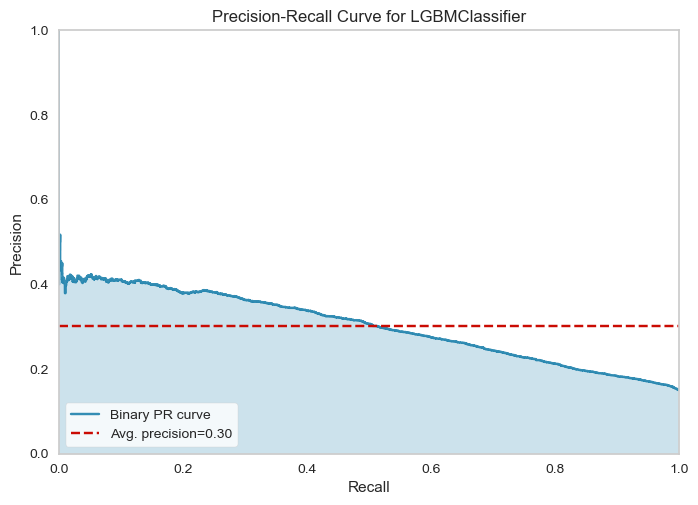

In [44]:
plot_model(tuned_lightgbm, plot = 'pr')

In [45]:
evaluate_model(tuned_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…